<a href="https://www.dask.org/" target="_blank">
<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">
</a>

# Parallel programming

In this notebook, we will explain how Dask enables the parallelization of basic sequential programs throught domain decomposition (data parallelism) and functional decomposition (task parallelism).

**Introduction**

Dask is a **library for parallel/distributed computing** in Python. 

* Python users can achieve **data parallelism**, by using Dask libraries such as `Dask Array` (mimic Numpy), `Dask DataFrame` (mimic Pandas), or `Dask Bag` (for large lists).
* Users can also achieve **task parallelism** by using libraries such as `Dask Delayed`.

**Content**

1. What is parallel programming
2. Problem decomposition strategies
3. Example

**Learning outcomes**
* Define parallel programmming
* Describe parallel programmming most common problem decomposition strategies.
* Identify which Dask data structures enable domain and functional decomposition.
* Exemplifies in which basic cases it is not worth parallelizing.

## 1. What is parallel programming

Parallel programmming is the use of two or more processor/cores in combination to solve a single problem.

In order to use two or more processor/cores **we must divivde the problem**.

Parallel programming is about **divide and conquer**, that is partitioning the problem in order to feed this partitions (chunks) into multiple processors in a single machine or a distributed system. Then processors can perform computations on these partitions at the same time.

| Sequential programming                                                                                        | Parallel programming                                                                                        |
|---------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|
| The problem was **NOT** devided by the programmer                                                            | The problem was divided by the programmer                                                                   |
| <img src="https://raw.githubusercontent.com/DonAurelio/dask-tutorial-2023/main/img/sequential_programming.png"> | <img src="https://raw.githubusercontent.com/DonAurelio/dask-tutorial-2023/main/img/parallel_programming.png"> |

# 2. Problem decomposition strategies

Problem decomposition (or division) is how parallel computing is achieved. Two decomposition strateties dominate when dealing with scientific and data analysis computations: domain and functional decomposition. 

**Domain decomposition or Data parallelism**

* The main idea is to **partition the domain of the problem**. In scientific computing, the problem domain is commonly represented via **vectors** and **matrices** whilst in data analystics, the problem domain is commonly represented via **data tables**.
* Implies partitioning data to processes such that *a single portion of data is assigned to a single core* [1].
* Implies the simulataneous execution of the same function (operation) across the elements of a dataset [2].

**Figure:** *[Left]* The domain is partitioned into chunks. Chucks are represenetd by colors. Every chunk is feed into a single core. *[Right]* Chunks in the figure are represented by subtables. Every subtable is feed into a single core.

| Array                                                                                                                             | Table                                                                                                                             |
|-----------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
|                                                         |
| <img src="https://raw.githubusercontent.com/DonAurelio/dask-tutorial-2023/main/img/domain_decomposition_array.png" width="600px"> | <img src="https://raw.githubusercontent.com/DonAurelio/dask-tutorial-2023/main/img/domain_decomposition_table.png" width="600px"> |


**Functional decomposition or Task parallelism** 

* The main idea is to **divide the code** used to solve a problem. This is commonly acheved by identifing functions, operations or secctions of the code that are independent of others.
* Implies partitioning code to processes such that *a single portion of code (e.g., a function) is assigned to a single core* [1].
* Implies the simultaneous execution of multiple and different functions across the same or different data sets [2].

**Figure:** *[Left]* The code represents the following ecuation $z = x^2 + y^2$ for $x=2$ and $y=4$. *[Right]* If the program is executed in a sequential approach, it will take 4 time steps. However, when considering functional decomposition, the same function `squared` can be applied in parallel to $2$ and $4$ since these values are independent. Then, the amount of time steps is reduced to 3.

<center>
<img src="https://raw.githubusercontent.com/DonAurelio/dask-tutorial-2023/main/img/functional_decomposition.png">
</center>

## 3. Example

**Problem**. Consider the following equation for arrays of shape `(1000, 1000)`. Suppose $x$ and $y$ are both matrices of ones.

$$
  z = x^2 + y^2
$$

We will solve the above mentioned problem using the following approaches:

1. Sequential porgrammming
2. Parallel programming: Automatic parallelization
3. Parallel programming: Domain decomposition
4. Parallel programming: Functional decomposition

A the end of this notebook, you should be able to provide answers to the following questions:

1. How many cores are we using when performing sequential programming?
2. How many cores we are able to use with parallel programming?
3. Which Dask data structure (Dask Array or Dask Delayed) enables domain decompositon for parallelziation?
4. Which Dask data structure (Dask Array or Dask Delayed) enables functional decompositon for parallelization?
5. Which parallelization strategy is the best (automatic paralleization, functional or domain decomposition) when considering the implemented algorithms?

### Sequential programming approach

Open the file [matrix_sum_python.py](source/1/0.matrix_sum_python.py).

In [ ]:
!srun -N 1 -c 1 time -f 'Time: %e seconds \nCPU usage: %P \nMem usage: %M kbytes' \
python3.10 source/1/0.matrix_sum_python.py

### Parallel programming approach: Automatic parallelization

Open the file [matrix_sum_numpy.py](source/1/1.matrix_sum_numpy.py).

In [2]:
!srun -N 1 --exclusive time -f 'Time: %e seconds \nCPU usage: %P \nMem usage: %M kbytes' \
python3.10 source/1/1.matrix_sum_numpy.py

Size of X 0.008000128 GB
Size of Y 0.008000128 GB
Size of Z 0.008000128 GB
Result
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]
Time: 0.15 seconds 
CPU usage: 4780% 
Mem usage: 63216 kbytes


### Parallel programming approach: Domain decomposition

In order to achieve parallelism, using the domain decomposition approach, we will use `Dask Array`. 

__1. Import required libraries, define required variables and functions__

In [3]:
import dask.array as da

shape = (1000,1000)
chunks = (100,100)

__2. Create the first array__ using `Dask Array` and perform domain decomposition. The `chucks` param tells Dask the size of every chuck in the decomposition. 

_Hint: Play with the `shape` and `chunks` params, observe the number of chucks created._

In [4]:
x = da.ones(shape=shape, chunks=chunks)
x

dask.array<ones_like, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

__3. Create the second array__ using `Dask Array` and perform domain decomposition.

In [5]:
y = da.ones(shape=shape, chunks=chunks)
y

dask.array<ones_like, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

__3. Write the parallel version of the program__

*Hint: you just need to write the equation $z = x^2 + y^2$ in Python langauge*

In [6]:
z = (x**2) + (y**2)
z

dask.array<add, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

__3. Visualize the computations.__

_Hint: These computations will be performed in all the cores available on your computer._

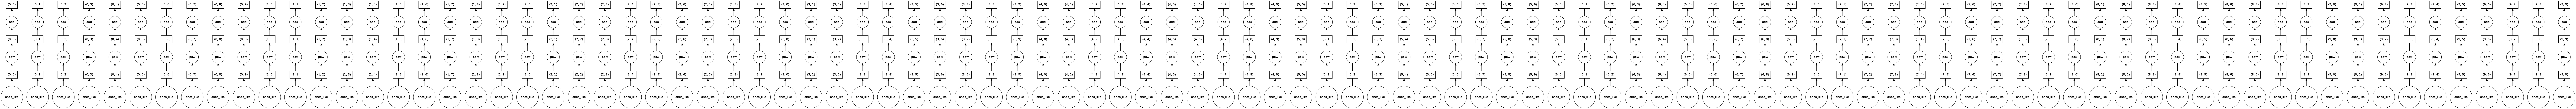

In [7]:
z.visualize()

**5. Compute the result** of the equation.

Open the file [matrix_sum_dask_array.py](source/1/2.matrix_sum_dask_array.py).

In [10]:
!srun -N 1 --exclusive time -f 'Time: %e seconds \nCPU usage: %P \nMem usage: %M kbytes' \
python3.10 source/1/2.matrix_sum_dask_array.py

Size of X 8e-08 GB
Size of Y 8e-08 GB
Time: 0.56 seconds 
CPU usage: 1364% 
Mem usage: 85016 kbytes


### Parallel programming approach: Functional decomposition

In order to achieve parallelism, using the functional decomposition approach, we will use `Dask Delayed`. However, **we need first to adjust our code** to be able to apply functional decomposition.

__1. Import required libraries, define required variables and functions__

**Remember the problem**. Consider the following equation for arrays of shape `(1000, 1000)`. Suppose $x$ and $y$ are both matrices of ones.

$$
  z = x^2 + y^2
$$

In [11]:
import dask

shape = (1000,1000)

def create_array():
    return [ [1 for x in range(0,shape[0])] for y in range(0,shape[1]) ]

def square(a):
    # __1. Square array (element-wise)__
    return [ [ (a[x][y]**2) for x in range(0,shape[0])] for y in range(0,shape[1]) ]

def add(a,b):
    # __1. Addition (element-wise)__
    return [ [ (a[x][y] + b[x][y]) for x in range(0,shape[0])] for y in range(0,shape[1]) ]

__2. Write the equation in terms of functions by using Delayed__

_Hint: you just need to write the equation $z = x^2 + y^2$ in Python langauge, but using the functions `squared` and `add` in place of `**` and `+`._

**Step 1.** Write the equation in terms of functions using plain Python.

```python
x = create_array()
y = create_array()
a = square(x)
b = square(y)
c = add(a,b)
```

**Step 2.** Convert functions into delayed objects.

```python
x = dask.delayed(create_array)()
y = dask.delayed(create_array)()
a = dask.delayed(square)(x)
b = dask.delayed(square)(y)
c = dask.delayed(add)(a,b)
```

__4. Run the parallel version of the program__ 

In [12]:
x = dask.delayed(create_array)()
y = dask.delayed(create_array)()
a = dask.delayed(square)(x)
b = dask.delayed(square)(y)
c = dask.delayed(add)(a,b)

__5. Visualize the computations__

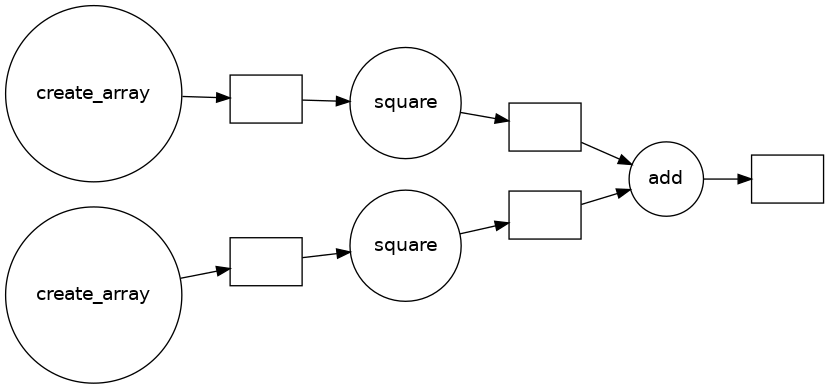

In [13]:
c.visualize(rankdir="LR")

__6. Execute the computation__

Open the file [matrix_sum_dask_delayed.py](source/1/3.matrix_sum_dask_delayed.py).

In [14]:
!srun -N 1 --exclusive time -f 'Time: %e seconds \nCPU usage: %P \nMem usage: %M kbytes' \
python3.10 source/1/3.matrix_sum_dask_delayed.py

Time: 2.27 seconds 
CPU usage: 410% 
Mem usage: 94944 kbytes


# [Excerise 1](labs/Lab1.ipynb)

# References

1. Vitorović, A., Tomašević, M. V., & Milutinović, V. M. (2014). Manual parallelization versus state-of-the-art parallelization techniques: The spec cpu2006 as a case study. In Advances in Computers (Vol. 92, pp. 203-251). Elsevier.
2. Terrell, R. (2018). Concurrency in. NET: Modern patterns of concurrent and parallel programming. Simon and Schuster.